In [1]:
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import time

sys.path.append('../utils')
import data_paths
from hbefa_hot_emissions import HbefaHotEmissions
from hot_emission_process import process_hourly_emissions
from traffic_counts import TrafficCounts

In [2]:
# initialize hbefa 
hbefa_obj = HbefaHotEmissions()
# initialize traffic cycles
cycles = TrafficCounts()
# import visum data
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS


# Use Inventory Model to calculate the Emission

In [3]:
road_links_with_detectors = df['road_link_id'].unique()
visum_reduced = visum_links[visum_links['road_link_id']\
    .isin(road_links_with_detectors)].copy()
visum_reduced = visum_reduced.reset_index(drop=True).reset_index()

In [4]:
final_emissions = list()

for day in pd.date_range(start='2019-01-01', end= '2019-12-31', freq = 'd'): # for all days in 2019
    
    em_dict = process_hourly_emissions(day.strftime('%Y-%m-%d'),
                                        visum_reduced.to_dict('records'),
                                        cycles,
                                        hbefa_obj)
    
    df_temp = pd.DataFrame()
    for road_link_index, item in em_dict.items():
        
        data = pd.DataFrame(pd.Series(item).reset_index())
        data.rename(columns = {'level_0':'vehicle_class',
                               'level_1':'component',
                               'level_2':'hour', 
                               0:'emission'},
                    inplace = True)
        data['date'] = day
        data['road_link_index'] = road_link_index
        df_temp = pd.concat([df_temp, data], axis = 0)
    final_emissions.append(df_temp)
model_dat = pd.concat(final_emissions)
model_dat['road_link_id'] = model_dat['road_link_index'].map(visum_reduced['road_link_id'].to_dict())
model_dat['timestamp'] = model_dat.apply(lambda row: pd.Timestamp.combine(row['date'],
                                                                          time(row['hour'])), axis = 1)

In [5]:
# serialize table
model_dat_long = model_dat.groupby(['vehicle_class',
                             'timestamp',
                             'road_link_id',
                             'component'])['emission'].sum().reset_index()

model_dat_long = model_dat_long.pivot(index = ['road_link_id', 'timestamp'],
                                      columns=['component', 'vehicle_class'],
                                      values = 'emission')

model_dat_long.head()

component                        BC (exhaust)       CH4        CO  \
vehicle_class                             BUS       BUS       BUS   
road_link_id timestamp                                              
38           2019-01-01 00:00:00     0.040884  0.002701  2.488030   
             2019-01-01 01:00:00     0.081767  0.005402  4.976061   
             2019-01-01 02:00:00     0.040884  0.002701  2.488030   
             2019-01-01 03:00:00     0.000000  0.000000  0.000000   
             2019-01-01 04:00:00     0.040884  0.002701  2.488030   

component                            CO2(rep)   CO2(total)         CO2e  \
vehicle_class                             BUS          BUS          BUS   
road_link_id timestamp                                                    
38           2019-01-01 00:00:00   694.106436   732.194771   717.678522   
             2019-01-01 01:00:00  1388.212873  1464.389541  1435.357045   
             2019-01-01 02:00:00   694.106436   732.194771   717.678522   
             2019-01-01 03:00:00     0.000000     0.000000     0.000000   
             2019-01-01 04:00:00   694.106436   732.194771   717.678522   

component                              NO2        NOx        PM BC (exhaust)  \
vehicle_class                          BUS        BUS       BUS          HGV   
road_link_id timestamp                                                         
38           2019-01-01 00:00:00  0.536536   5.452796  0.066002     0.223761   
             2019-01-01 01:00:00  1.073071  10.905591  0.132003     0.279701   
             2019-01-01 02:00:00  0.536536   5.452796  0.066002     0.223761   
             2019-01-01 03:00:00  0.000000   0.000000  0.000000     0.223761   
             2019-01-01 04:00:00  0.536536   5.452796  0.066002     0.223761   

component                         ...        PM BC (exhaust)       CH4  \
vehicle_class                     ...       MOT           PC        PC   
road_link_id timestamp            ...                                    
38           2019-01-01 00:00:00  ...  0.133923     1.187643  3.750067   
             2019-01-01 01:00:00  ...  0.133923     0.935846  2.955000   
             2019-01-01 02:00:00  ...  0.133923     0.625296  1.974417   
             2019-01-01 03:00:00  ...  0.000000     0.516184  1.629888   
             2019-01-01 04:00:00  ...  0.000000     0.465825  1.470874   

component                                 CO      CO2(rep)    CO2(total)  \
vehicle_class                             PC            PC            PC   
road_link_id timestamp                                                     
38           2019-01-01 00:00:00  407.383822  91207.794515  95655.806269   
             2019-01-01 01:00:00  321.012694  71870.452922  75375.423314   
             2019-01-01 02:00:00  214.488302  48021.064957  50362.951004   
             2019-01-01 03:00:00  177.060813  39641.550266  41574.785057   
             2019-01-01 04:00:00  159.786587  35774.081948  37518.708466   

component                                 CO2e        NO2         NOx  \
vehicle_class                               PC         PC          PC   
road_link_id timestamp                                                  
38           2019-01-01 00:00:00  92381.364468  41.727961  220.601901   
             2019-01-01 01:00:00  72795.209457  32.881043  173.831180   
             2019-01-01 02:00:00  48638.951610  21.969845  116.147291   
             2019-01-01 03:00:00  40151.617772  18.136181   95.879978   
             2019-01-01 04:00:00  36234.386770  16.366797   86.525834   

component                               PM  
vehicle_class                           PC  
road_link_id timestamp                      
38           2019-01-01 00:00:00  2.223409  
             2019-01-01 01:00:00  1.752015  
             2019-01-01 02:00:00  1.170629  
             2019-01-01 03:00:00  0.966358  
             2019-01-01 04:00:00  0.872079  

[5 rows x 45 columns]

# Import detector-based emissions for comparison

In [6]:
# import detector emission data
_fname = data_paths.INVENTORY_FOLDER_PATH + 'detector_emissions_v_ts.feather'
df = pd.read_feather(_fname)

# Prepare combined dataset

In [37]:
component = 'CO2(rep)'
ground_truth_em = df.groupby(['road_link_id',
                              'timestamp'])[[f'{component}_{x}' for x in hbefa_obj.vehicle_classes]].sum()

model_hourly_co2_sum = model_dat_long[component].sum(axis =1)
ground_truth_hourly_co2_sum = ground_truth_em.sum(axis=1)

comp_df = pd.concat([ground_truth_hourly_co2_sum, 
                     model_hourly_co2_sum], axis =1).dropna()
comp_df_base = comp_df[(comp_df[0]>1) &
                       (comp_df[1]>1)]

comp_df_base = comp_df_base.rename(columns = {0: 'true_em', 1: 'modeled_em'})
comp_df_base.head()

true_em     modeled_em
road_link_id timestamp                                        
38.0         2019-01-02 23:00:00  155549.855148  139895.796508
             2019-01-03 00:00:00   94208.239563   62620.797533
             2019-01-03 01:00:00   76517.434746   44507.268569
             2019-01-03 02:00:00   68377.867950   38030.332721
             2019-01-03 03:00:00   61610.871429   40835.143343

# Calculate hourly differences

-261657.31609168215
280732.63770380453
18.50277783742075


<Axes: xlabel='diff', ylabel='Count'>

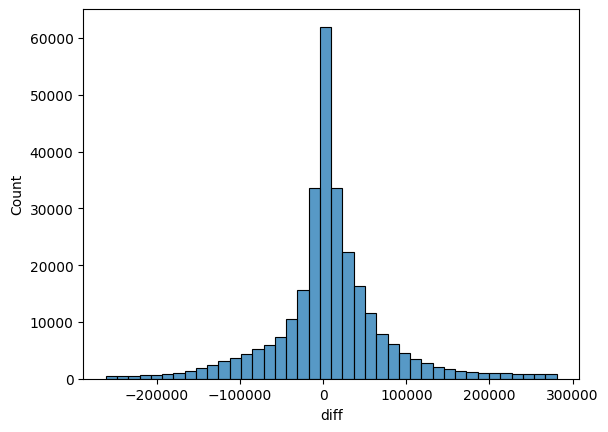

In [56]:
hourly_comp = comp_df_base.copy()
hourly_comp['diff'] = hourly_comp['true_em'] - hourly_comp['modeled_em']
hourly_comp['diff_rel'] = (hourly_comp['diff']/ hourly_comp['true_em'])*100

vals = hourly_comp['diff'][np.isfinite(hourly_comp['diff'].to_numpy())]
lb = np.nanpercentile(vals, 2.5)
ub = np.percentile(vals, 97.5)

print(lb)
print(ub)
print(vals.std()/vals.mean())

sns.histplot(hourly_comp, x='diff',  binrange= (lb,ub), bins= 40)

# Calculate Daily Differences

-4895629.034091822
5306803.68338556
14.054508190886347


<Axes: xlabel='diff', ylabel='Count'>

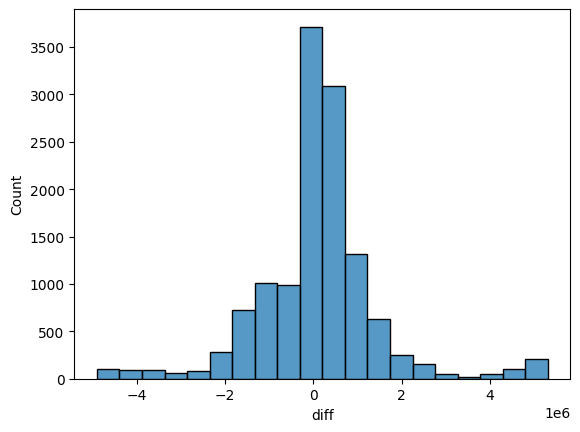

In [58]:
daily_comp = comp_df_base.reset_index().set_index('timestamp').copy()
daily_comp = daily_comp.groupby('road_link_id').resample('D').sum()

daily_comp['diff'] = daily_comp['true_em'] - daily_comp['modeled_em']
daily_comp['diff_rel'] = (daily_comp['diff']/daily_comp['true_em'])*100

vals = daily_comp['diff'][np.isfinite(daily_comp['diff'].to_numpy())]
lb = np.nanpercentile(vals, 2.5)
ub = np.percentile(vals, 97.5)

print(lb)
print(ub)
print(vals.std()/vals.mean())

sns.histplot(daily_comp, x='diff',  binrange= (lb, ub), bins= 20)

# Calculate Annual Differences

-955569245.0285155
1624484362.4146295
14.028442240949849


<Axes: xlabel='diff', ylabel='Count'>

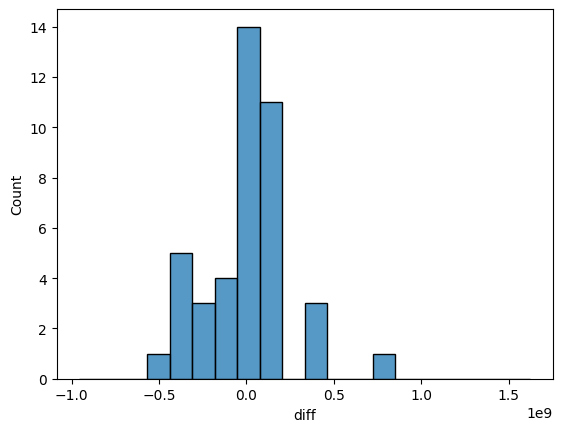

In [59]:
# calculate for a whole year

annual_comp = comp_df_base.reset_index().set_index('timestamp').copy()
annual_comp = annual_comp.groupby('road_link_id').resample('Y').sum()

annual_comp['diff'] = annual_comp['true_em'] - annual_comp['modeled_em']
annual_comp['diff_rel'] = (annual_comp['diff']/annual_comp['true_em'])*100

vals = annual_comp['diff'][np.isfinite(annual_comp['diff'].to_numpy())]
lb = np.nanpercentile(vals, 2.5)
ub = np.percentile(vals, 97.5)

print(lb)
print(ub)
print(vals.std()/vals.mean())

sns.histplot(annual_comp, x='diff', binrange = (lb, ub), bins= 20)

In [50]:
vals

road_link_id  timestamp 
3.800000e+01  2019-12-31    7.347273e+08
7.200000e+01  2019-12-31    3.727005e+08
4.190000e+02  2019-12-31    3.483926e+08
1.068000e+03  2019-12-31    1.908147e+08
9.655000e+03  2019-12-31    1.795089e+07
1.235000e+04  2019-12-31    1.209016e+08
1.268100e+04  2019-12-31    6.164172e+07
1.288900e+04  2019-12-31    2.250702e+07
1.289500e+04  2019-12-31   -3.251872e+08
1.298600e+04  2019-12-31   -5.313819e+07
1.317600e+04  2019-12-31    4.185308e+08
1.358700e+04  2019-12-31   -4.279592e+08
1.368200e+04  2019-12-31    3.893202e+07
1.557100e+04  2019-12-31   -1.880205e+09
1.602500e+04  2019-12-31   -1.423565e+08
1.614400e+04  2019-12-31   -1.883353e+08
1.618400e+04  2019-12-31   -1.308552e+07
4.739100e+04  2019-12-31    1.020064e+08
4.811600e+04  2019-12-31   -3.133380e+08
8.060900e+04  2019-12-31   -3.144451e+07
8.064500e+04  2019-12-31    2.930194e+07
5.280434e+07  2019-12-31    1.322914e+08
              2019-12-31    6.483052e+07
5.280879e+07  2019-12-31    8.07